In [52]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import pylab
from statsmodels.stats.weightstats import zconfint

In [36]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/s.komissarov/opt/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['pylab']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Критерии Стьюдента

In [2]:
t = (9.57 - 9.5) / (0.4 / np.sqrt(160))

In [10]:
round(2 * (1 - stats.norm.cdf(t)), 4)

0.0269

------------------------------------

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [12]:
data = pd.read_csv('diamonds.txt', sep='\t')

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 7 columns):
carat    53940 non-null float64
depth    53940 non-null float64
table    53940 non-null float64
price    53940 non-null int64
x        53940 non-null float64
y        53940 non-null float64
z        53940 non-null float64
dtypes: float64(6), int64(1)
memory usage: 2.9 MB


In [16]:
y = data['price']
X = data.drop('price', axis=1)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, train_size=0.75)

In [21]:
%%time
lr = LinearRegression()
rf = RandomForestRegressor(random_state=1)

lr.fit(X_train, y_train)
rf.fit(X_train, y_train)

pred_lr = lr.predict(X_test)
pred_rf = rf.predict(X_test)

/Users/s.komissarov/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 1.34 s, sys: 63.2 ms, total: 1.41 s
Wall time: 1.57 s


In [25]:
diff_lr = np.abs(pred_lr - y_test)
diff_rf = np.abs(pred_rf - y_test)

In [33]:
np.mean(diff_lr), np.mean(diff_rf)

(890.3764004285589, 802.9205172724141)

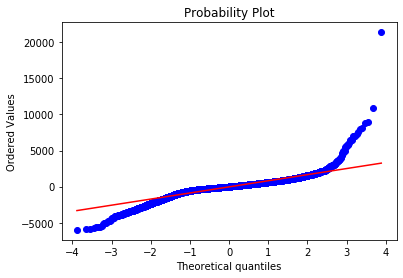

In [37]:
stats.probplot(pred_lr - pred_rf, dist = "norm", plot = pylab)
pylab.show()

In [42]:
d = pred_lr - pred_rf
S = pd.Series(d).std()

In [49]:
t = (np.mean(pred_lr) - np.mean(pred_rf)) / (S / np.sqrt(pred_lr.shape[0]))

In [50]:
stats.norm.cdf(t)

0.00014057594667878318

In [56]:
zconfint(np.abs(d))

(565.1649019972559, 589.3191994796501)

In [57]:
round(zconfint(np.abs(d))[0])

565.0

### Параметрические критерии

In [58]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [59]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [115]:
sample1 = np.zeros(34)
sample1[:10] = 1
sample2 = np.zeros(16)
sample2[:4] = 1

In [116]:
z = proportions_diff_z_stat_ind(sample1, sample2)

In [117]:
round(proportions_diff_z_test(z, 'greater'), 4)

0.3729

---

In [78]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [67]:
data = pd.read_csv('banknotes.txt', sep='\t')

In [70]:
y = data['real']
X = data.drop(['real'], axis=1)

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=50, random_state=1)

In [129]:
lr1 = LogisticRegression(multi_class='ovr', n_jobs=1, solver='liblinear')
lr2 =LogisticRegression(multi_class='ovr', n_jobs=1, solver='liblinear')

lr1.fit(X_train[['X1', 'X2', 'X3']], y_train)
lr2.fit(X_train[['X4', 'X5', 'X6']], y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
                   solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [130]:
pred_1 = lr1.predict(X_test[['X1', 'X2', 'X3']])
pred_2 = lr2.predict(X_test[['X4', 'X5', 'X6']])

In [138]:
p_1 = (pred_1 != y_test).astype('Int64')
p_2 = (pred_2 != y_test).astype('Int64')

In [131]:
1 - accuracy_score(y_test, pred_1), 1 - accuracy_score(y_test, pred_2)

(0.19999999999999996, 0.020000000000000018)

In [132]:
def proportions_diff_z_stat_rel(sample1, sample2):
    sample = list(zip(sample1, sample2))
    n = len(sample)
    
    f = sum([1 if (x[0] == 1 and x[1] == 0) else 0 for x in sample])
    g = sum([1 if (x[0] == 0 and x[1] == 1) else 0 for x in sample])
    
    return float(f - g) / np.sqrt(f + g - float((f - g)**2) / n )

def proportions_diff_confint_rel(sample1, sample2, alpha = 0.05):
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    sample = list(zip(sample1, sample2))
    n = len(sample)
        
    f = sum([1 if (x[0] == 1 and x[1] == 0) else 0 for x in sample])
    g = sum([1 if (x[0] == 0 and x[1] == 1) else 0 for x in sample])
    
    left_boundary = float(f - g) / n  - z * np.sqrt(float((f + g)) / n**2 - float((f - g)**2) / n**3)
    right_boundary = float(f - g) / n  + z * np.sqrt(float((f + g)) / n**2 - float((f - g)**2) / n**3)
    return (left_boundary, right_boundary)

In [139]:
z1 = proportions_diff_z_stat_ind(p_1, p_2)
z2 = proportions_diff_z_stat_rel(p_1, p_2)
print(proportions_diff_z_test(z1), proportions_diff_z_test(z2))
print(proportions_diff_z_test(z1, 'less'), proportions_diff_z_test(z2, 'less'))
print(proportions_diff_z_test(z1, 'greater'), proportions_diff_z_test(z2, 'greater'))

0.004022237272055307 0.0032969384555543435
0.9979888813639723 0.9983515307722228
0.0020111186360276534 0.0016484692277771718


In [140]:
interval = proportions_diff_confint_rel(p_1, p_2)
print('{:.4f} {:.4f}'.format(interval[0], interval[1]))

0.0599 0.3001


---

In [110]:
z = (541.4 - 525) / (100 / np.sqrt(100))

In [114]:
round(1 - stats.norm.cdf(z), 4), round(stats.norm.cdf(z), 4)

(0.0505, 0.9495)

### Непараметрические критерии

In [191]:
from statsmodels.stats.descriptivestats import sign_test

data = np.array([49,58,75,110,112,132,151,276,281,362])

In [192]:
res = sign_test(data, 200)
round(res[1], 4)

0.3437

In [196]:
round(scipy.stats.wilcoxon(data - 200).pvalue, 4)

0.2845

---

In [159]:
data1 = np.array([22, 22, 15, 13, 19, 19, 18, 20, 21, 13, 13, 15])
data2 = np.array([17,18,18,15,12,4,14,15,10])
data1.shape, data2.shape

((12,), (9,))

In [164]:
round(stats.mannwhitneyu(data1, data2).pvalue, 4)

0.029

---

In [197]:
data = pd.read_csv('challenger.txt', sep='\t')

In [198]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [239]:
np.random.seed(0)

df_0 = data[data['Incident'] == 1]['Temperature'].values
df_1 = data[data['Incident'] == 0]['Temperature'].values

median_0 = list(map(np.mean, get_bootstrap_samples(df_0, 1000)))
median_1 = list(map(np.mean, get_bootstrap_samples(df_1, 1000)))

In [240]:
delta_median_scores = list(map(lambda x: x[1] - x[0], zip(median_0, median_1)))

In [241]:
print("95% confidence interval for the difference between medians",  stat_intervals(delta_median_scores, 0.05))

95% confidence interval for the difference between medians [1.45040179 8.06457589]


In [243]:
round(stat_intervals(delta_median_scores, 0.05)[0], 4)

1.4504

---

In [186]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

def get_random_combinations(n1, n2, max_combinations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), list(filter(lambda i: i not in index, range(n)))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [244]:
permutation_test(df_0, df_1, max_permutations = 10000)

0.0067